## Importing Libraries

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

#Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
#path = "/content/drive/MyDrive/Colab Notebooks/RL_cab/TM.npy"
path = "TM.npy"
Time_matrix = np.load(path)

#### Initializing for state-action pairs 

In [3]:
# Tracking q-values for all possible moves from position 4 at the start of the episode
States_track = collections.defaultdict(dict)
def initialise_tracking_states(state,actions):
    for q_value in actions:
        States_track[state][q_value] = []

In [4]:
def update_tracking_states(track_state):
    st = np.array(env.state_encod_arch1(track_state)).reshape(1,36)
    q_value = agent.model.predict(st)
    for i,state in enumerate(States_track[track_state].keys()):
        States_track[track_state][state].append(q_value[0][i])

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### DQN Agent

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon_max = 1
        self.epsilon_decay = -0.001
        self.epsilon_min = 0.00001
        self.epsilon = 1
        
        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        #model.summary()
        return model

    def get_action(self, state, possible_actions):
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions)
        else :
            state_encoded = np.array(env.state_encod_arch1(state)).reshape(1,36)
            q_value = self.model.predict(state_encoded)
            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions]

            return (possible_actions[np.argmax(q_vals_possible)])

    def append_sample(self, state, action_idx, reward, next_state,done):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_idx, reward, next_state, done))
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_bool = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                done.append(done_bool)
                update_output[i] = env.state_encod_arch1(next_state)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)    
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)    
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                else:
                    target[i][actions[i]] = rewards[i]
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)

### Initializing Env and Agent class
#### Definining Episode and tracking state

In [7]:
Episodes = 4000
env = CabDriver()
traker_state = (4,0,0)
initialise_tracking_states(traker_state,env.action_space)
agent = DQNAgent(env.state_size,env.action_size)

### Epsilon Convergence Graph

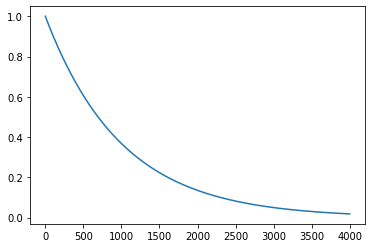

In [8]:
cnt = Episodes
time = np.arange(0,cnt)
epsilon = []
for i in range(0,cnt):
    epsilon.append((1 - 0.00001) * np.exp(agent.epsilon_decay*i))

plt.plot(time, epsilon)
plt.show()

### To load model weights

In [16]:
#wpath = 'model_weight/weight2_3999'
#agent.model.load_weights(wpath)

### Training Loop 

In [ ]:
rewards_per_episode, episodes = [], []
reward_track = []
for episode in range(Episodes):
    action_space, state_space, state = env.reset()
    triptime = 0
    terminal_state = False
    score = 0
    start_time = time.time()
    while not terminal_state:
        possible_actions_index, actions = env.requests(state)
        #print(f"PAi{possible_actions_index},Ac:{actions} for S:{state}")
        action_idx = agent.get_action(state,possible_actions_index)
        #print(f"Action_idx:{action_idx},{action_space[action_idx]}")
        next_state,reward,step_time = env.step(state,env.action_space[action_idx],Time_matrix)
        #print(f"Ns:{next_state},R:{reward},T:{step_time}")
        triptime += step_time
        
        if triptime >= (24*30):
            terminal_state = True
        else:
            agent.append_sample(state,action_idx,reward,next_state,terminal_state)
            agent.train_model()
            score += reward
            state = next_state
            
    update_tracking_states(traker_state)
    reward_track.append(score)

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    # Debug logs
    if (episode % 50) == 0:
        print(f"E:{episode},\tR:{score},\tT_c:{(time.time()-start_time):.2f},\tM:{len(agent.memory)}")
    # periodic saving the weights and tracking data
    if (episode % 200) == 0:
        save_obj(States_track,f"/content/drive/MyDrive/Colab Notebooks/RL_cab/save_model/state/state1_{episode}")
        save_obj(reward_track,f"/content/drive/MyDrive/Colab Notebooks/RL_cab/save_model/state/reward1_{episode}")
        agent.model.save_weights(f"/content/drive/MyDrive/Colab Notebooks/RL_cab/save_model/weights/weight1_{episode}")

E:0,	R:-303.0,	T_c:11.21,	M:151
E:50,	R:-165.0,	T_c:10.17,	M:2000
E:100,	R:-305.0,	T_c:10.17,	M:2000
E:150,	R:-79.0,	T_c:12.90,	M:2000
E:200,	R:-439.0,	T_c:10.04,	M:2000
E:250,	R:-323.0,	T_c:9.92,	M:2000
E:300,	R:87.0,	T_c:12.17,	M:2000
E:350,	R:88.0,	T_c:10.76,	M:2000
E:400,	R:-59.0,	T_c:10.15,	M:2000
E:450,	R:-417.0,	T_c:11.22,	M:2000
E:500,	R:-121.0,	T_c:9.28,	M:2000
E:550,	R:82.0,	T_c:11.20,	M:2000
E:600,	R:-280.0,	T_c:11.73,	M:2000
E:650,	R:11.0,	T_c:10.44,	M:2000
E:700,	R:-354.0,	T_c:11.33,	M:2000
E:750,	R:-263.0,	T_c:11.00,	M:2000
E:800,	R:-175.0,	T_c:10.36,	M:2000
E:850,	R:-344.0,	T_c:10.08,	M:2000
E:900,	R:176.0,	T_c:11.00,	M:2000
E:950,	R:14.0,	T_c:12.14,	M:2000
E:1000,	R:-229.0,	T_c:10.96,	M:2000
E:1050,	R:52.0,	T_c:9.37,	M:2000
E:1100,	R:-146.0,	T_c:10.50,	M:2000
E:1150,	R:-157.0,	T_c:11.22,	M:2000
E:1200,	R:64.0,	T_c:12.38,	M:2000
E:1250,	R:-382.0,	T_c:11.56,	M:2000
E:1300,	R:-196.0,	T_c:10.23,	M:2000
E:1350,	R:353.0,	T_c:10.25,	M:2000
E:1400,	R:-30.0,	T_c:9.18,	M:2000
E:1

## State-Action pair plot for Q_value vs Episode

In [9]:
qpath = 'state2_3999.pkl'
with open(qpath, 'rb') as handle:
    States_track = pickle.load(handle)

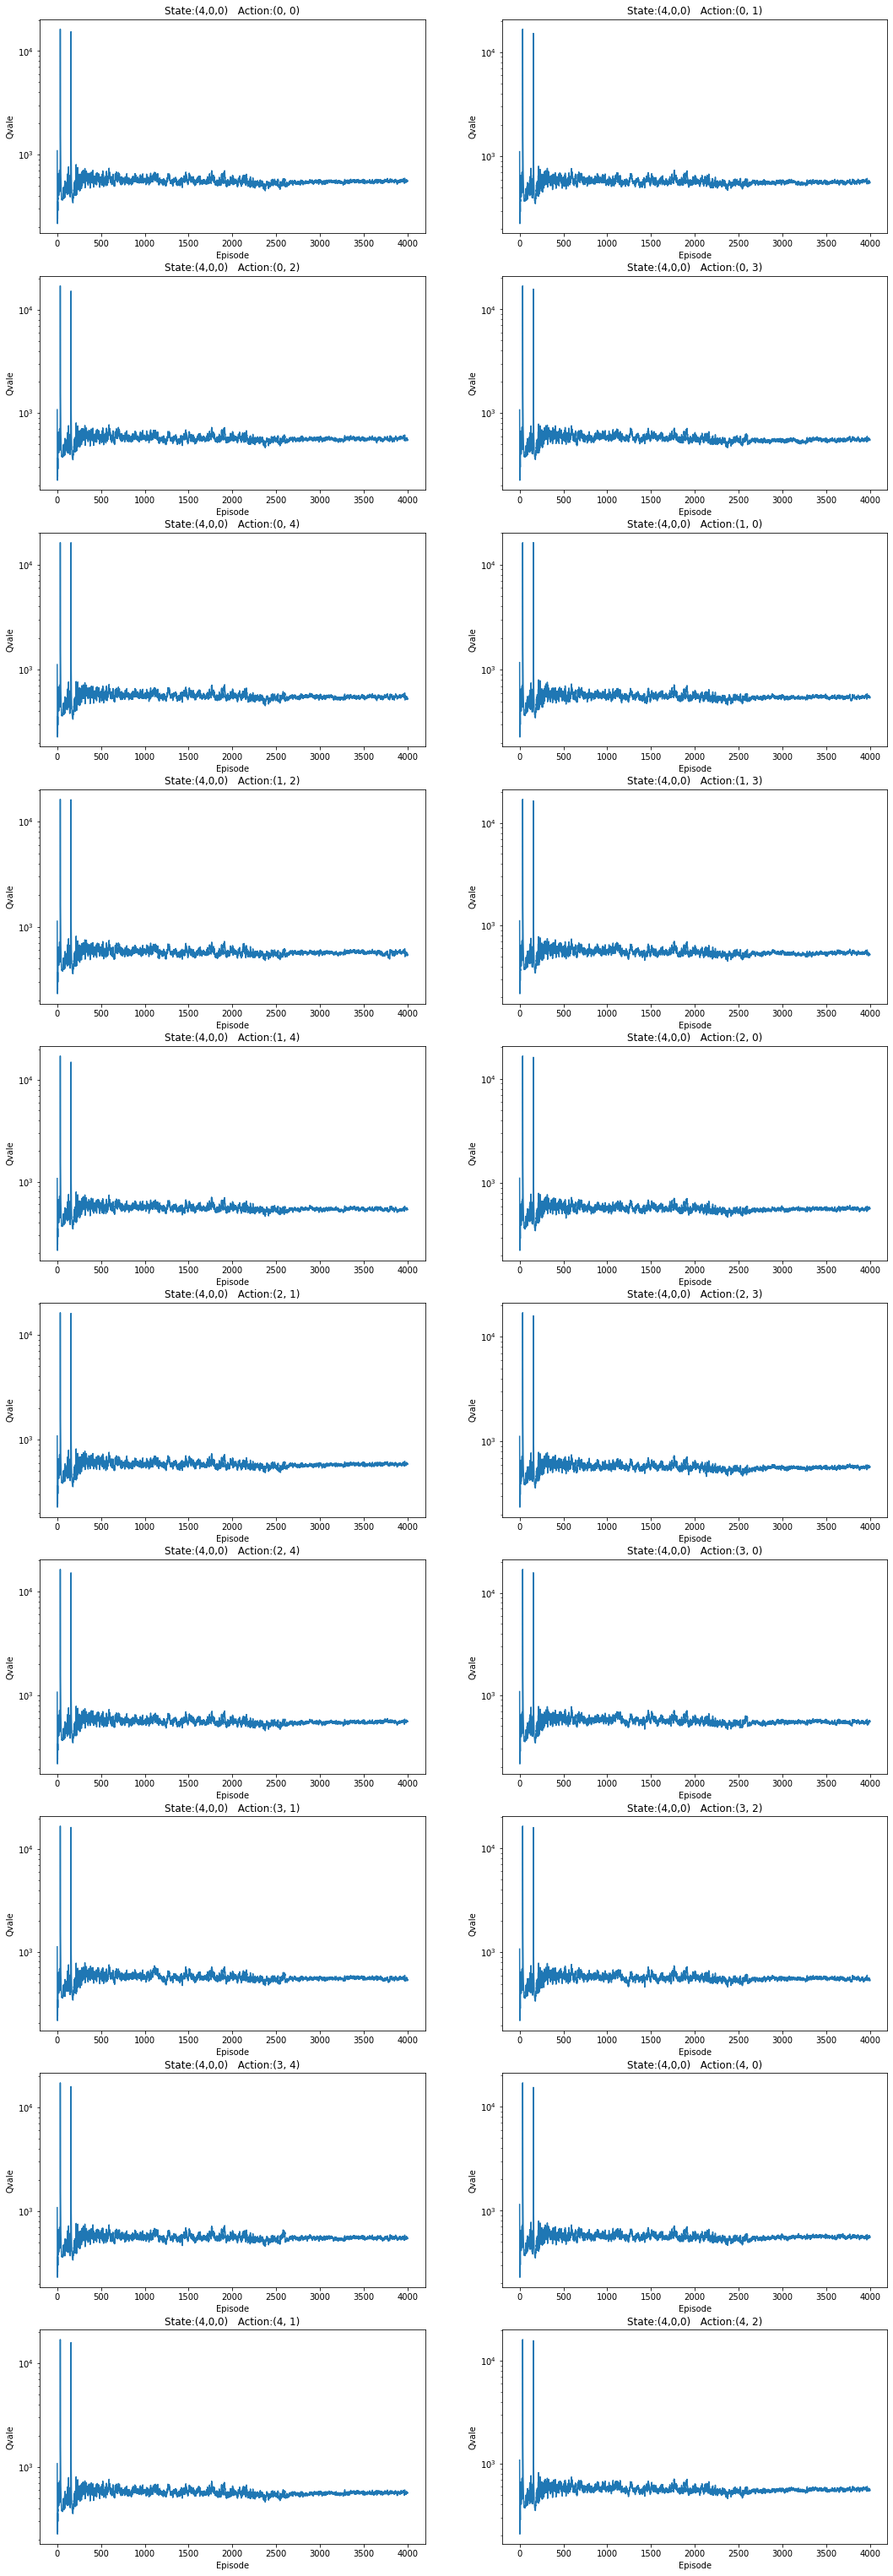

In [11]:
plt.figure(0, figsize=(18, 55))

for cnt,i in enumerate(States_track[(4,0,0)].keys()):
    plt.subplot(10,2,cnt+1)
    plt.title(f"State:(4,0,0)   Action:{i}")
    plt.xlabel("Episode")
    plt.ylabel("Qvale")
    plt.plot(States_track[(4,0,0)][i])
    plt.yscale("log")
    if cnt == 19:
        break
plt.show()